# Visualize in situ observations and numerical results of PAR over one year

# First, load libraries

In [1]:
import netcdf_tools
import numpy as np
import pandas as pd
import pathlib
import scipy
import scipy.interpolate
import vstats

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

plt.close("all")

# Select year

In [2]:
years=range(1,11)
nbyears=len(years)
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT=last_year
first_year366=np.arange(0,366) # first year for heatmaps

# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

it corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [3]:
gridfile='grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m)

In [4]:
RC=netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m)

In [5]:
RF=netcdf_tools.read_netcdf(gridfile,'RF')

In [6]:
RF_above81=RF[RF>-82]

# Ice

In [7]:
ice=np.fromfile('../../gud_1d_35+16/input_noradtrans/input/siarea.qik.2016.365.32bits.bin',
                dtype='>f')

In [8]:
iT15=np.nonzero(ice<0.15)[0]
iT15_start=iT15[0]
iT15_end=iT15[-1]

# Configure plots

In [9]:
# adapted from
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
# answer of Pedro M Duarte
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 56

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the x tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the y tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Observations

Create directory validation if it doesn't exit.

In [10]:
pathlib.Path("validation").mkdir(parents=True, exist_ok=True)

## Observations of PAR just below surface

### Observations of PAR just below surface: Load dataset

In [11]:
def load_par():
    fname='../../obs/66399.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'station': 'category',
                'date': str,
                'snow_thickness': 'category',
                'depth_m': np.float32,
                'pi': 'category',
                'averaged_par_d_fit_muein_m_2_s_1': np.float32,
                'averaged_par_d_fit_percent_percent': np.float32,
                'averaged_par_d_fit_daily_ein_m_2_day_1': np.float32,
                'averaged_par_d_noon1hloc_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p1h_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p3h_ein_m_2_3h_1': np.float32,
                'averaged_par_d_p24h_ein_m_2_day_1': np.float32,
                'averaged_par_d_p48h_ein_m_2_48h_1': np.float32
            },
            parse_dates=['date']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                averaged_par_d_fit_daily_ein_m_2_day_1='par',
            )
        )
    )
    df['depth']=-df['depth'] # negative depths
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [12]:
par_df=load_par()

### Observations of PAR just below surface: Select

In [13]:
par_df=par_df[par_df.mission=='ice_camp_2016']

find negative PAR

In [14]:
par_df['par'][par_df['par']<0]

Series([], Name: par, dtype: float32)

find duplicates

In [15]:
g=par_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: depth, dtype: float64)

### Observations of PAR just below surface: calculate

In [16]:
parwater_df=(par_df.dropna(subset=['par'])).copy()
for doy in pd.unique(parwater_df['doy']):
    ice_thickness=-parwater_df.loc[(parwater_df.doy==doy),('depth')].max()
    parwater_df.loc[parwater_df.doy==doy,'depth']\
    =parwater_df.loc[parwater_df.doy==doy,'depth']+ice_thickness

### Observations of PAR just below surface: Load dataset

In [17]:
def load_par():
    fname='../../obs/66399.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'station': 'category',
                'date': str,
                'snow_thickness': 'category',
                'depth_m': np.float32,
                'pi': 'category',
                'averaged_par_d_fit_muein_m_2_s_1': np.float32,
                'averaged_par_d_fit_percent_percent': np.float32,
                'averaged_par_d_fit_daily_ein_m_2_day_1': np.float32,
                'averaged_par_d_noon1hloc_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p1h_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p3h_ein_m_2_3h_1': np.float32,
                'averaged_par_d_p24h_ein_m_2_day_1': np.float32,
                'averaged_par_d_p48h_ein_m_2_48h_1': np.float32
            },
            parse_dates=['date']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                averaged_par_d_fit_daily_ein_m_2_day_1='par',
            )
        )
    )
    df['depth']=-df['depth'] # negative depths
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [18]:
par_df=load_par()

### Observations of PAR just below surface: Select

In [19]:
par_df=par_df[par_df.mission=='ice_camp_2016']

find negative PAR

In [20]:
par_df['par'][par_df['par']<0]

Series([], Name: par, dtype: float32)

find duplicates

In [21]:
g=par_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: depth, dtype: float64)

Observations of PAR just below surface: Plot on observations grid

### Observations of PAR just below surface: calculate

In [22]:
parwater_df=(par_df.dropna(subset=['par'])).copy()
for doy in pd.unique(parwater_df['doy']):
    ice_thickness=-parwater_df.loc[(parwater_df.doy==doy),('depth')].max()
    parwater_df.loc[parwater_df.doy==doy,'depth']\
    =parwater_df.loc[parwater_df.doy==doy,'depth']+ice_thickness

In [23]:
nT=365
array1d_iT_obsmeanPAR=np.full(nT,np.nan)
for doy in pd.unique(parwater_df['doy']):
    parwater_onedoy_df=parwater_df[parwater_df.doy==doy]
    par=parwater_onedoy_df.iloc[0]['par']
    array1d_iT_obsmeanPAR[doy-1]=par

## Observations of PAR

### Observations of PAR: Plot on model grid

In [24]:
RC_above151=np.array(RC[RC>-151])
array2d_iRC_iT_obspar=np.empty([RC_above151.size,array1d_iT1y_iT.size])
array2d_iRC_iT_obspar[:,:]=np.nan
for doy in pd.unique(parwater_df['doy']):
    parwater_onedoy_df=parwater_df[parwater_df.doy==doy]
    y_interp=scipy.interpolate.interp1d(
            parwater_onedoy_df['depth'],
            parwater_onedoy_df['par'],
            bounds_error=False)
    array1d_iRC_par=y_interp(RC_above151)
    array2d_iRC_iT_obspar[:,doy-1]=array1d_iRC_par
isnan=np.isnan(array2d_iRC_iT_obspar)
array2d_iRC_iT_obspar[isnan]=np.finfo(float).eps
marray2d_iRC_iT_obspar=np.ma.array(array2d_iRC_iT_obspar,
                                   mask=isnan)

In [25]:
plt.rcdefaults()

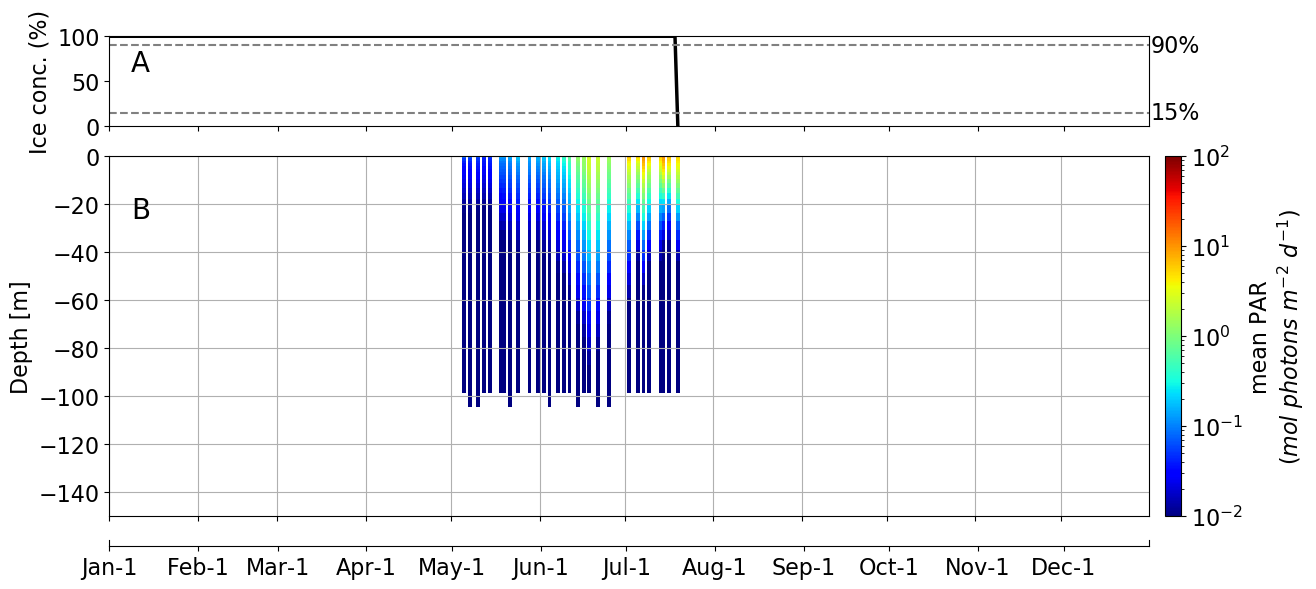

In [26]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
        'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

RF_above151=RF[RF>-151]
fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

# --- ICE CONCENTRATIONS
obsice=np.empty(365)
obsice[:]=np.NaN
obsice[0:199]=1
obsice[199]=0
ax=axs[0]
ax.plot(first_year,obsice*100,'k-',lw=2.5)
ax.set_xlim(first_year[0],first_year[-1])
xlims=ax.get_xlim()
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Ice conc. (%)')
ax.set_ylim(0,100)
ax.plot(xlims,[15,15],'k--',color='gray')
ax.plot(xlims,[90,90],'k--',color='gray')
ax.text(xlims[1]+.5,15,'15%',verticalalignment='center')
ax.text(xlims[1]+.5,90,'90%',verticalalignment='center')
plt.text(0.03,0.7,'A',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20)

# --- PANEL B: PAR
ax=axs[1]
RF_above151=RF[RF>-151]
h=ax.pcolormesh(first_year366,
                RF_above151,
                marray2d_iRC_iT_obspar[0:(RF_above151.size)-1,:],
                cmap='jet',
                norm=mpl.colors.LogNorm(vmin=0.01,vmax=100))
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Depth [m]')
ax.set_ylim(-150,0)
ax.grid()

# adding the colorbar
cbaxes = fig.add_axes([0.78, 0.15, 0.01, 0.60])
cb = plt.colorbar(h,
                  cax=cbaxes)
cb.set_label('mean PAR\n($mol\ photons\ m^{-2}\ d^{-1}$)')

plt.text(0.03,0.85,'B',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20, color='k')

# --- ADDITIONAL X-AXIS
ax=axs[2]
ax.set_xlim(xlims)
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)

# --- POSITION
axs[0].set_position( [0.12,0.80  ,0.65,0.15])
axs[1].set_position( [0.12,0.15  ,0.65,0.60])
axs[2].set_position( [0.12,0.10  ,0.65,0.01])

# --- SAVE
plt.savefig('validation/GEic2016.par.png')

# Forcings

## Forcings: PAR_ice file

in $mol\ photons\ m^{-2}\ d^{-1}$

In [27]:
array1d_iT_PAR_icefileumolEonm2s=np.fromfile('../../gud_1d_35+16/input_noradtrans/input/1D_obs_PARice_EXP0_y2016.365.32bits.bin',
                                                dtype='>f')
stod=86400 # 3600*24 s per d
array1d_iT_PAR_icefile=array1d_iT_PAR_icefileumolEonm2s*1e-6*stod

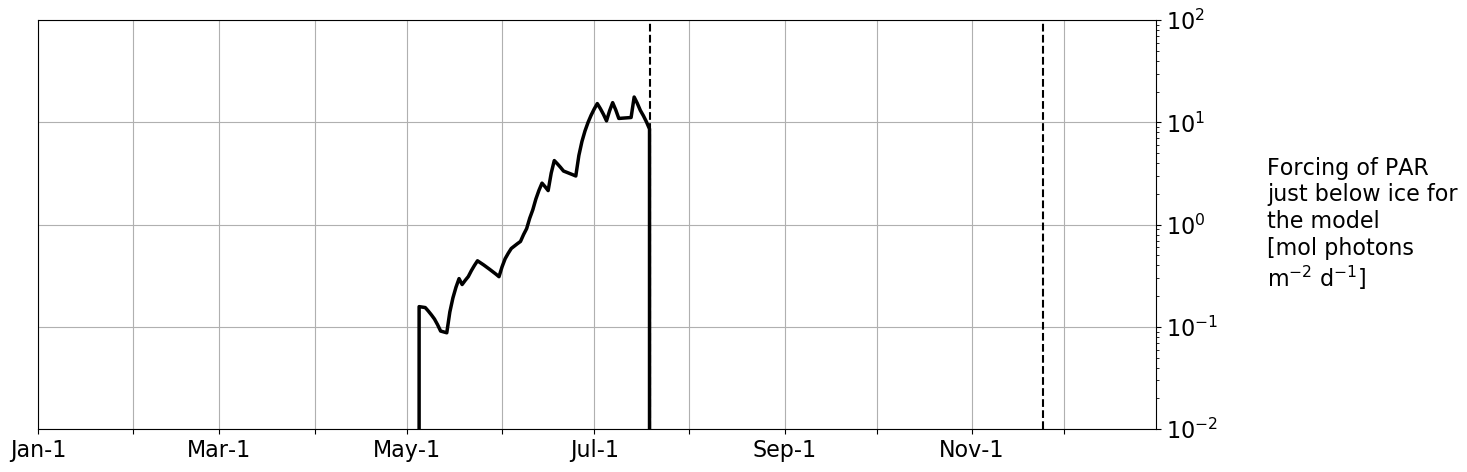

In [28]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','','Mar-1','','May-1','',
        'Jul-1','','Sep-1','','Nov-1','')

plt.figure(figsize=(15,5))
ax = plt.gca()
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.plot(first_year,array1d_iT_PAR_icefile,'k-',lw=2.5)
ax.set_yscale('log')
ax.yaxis.tick_right()
ax.grid()
ax.set_xlim(first_year[0],first_year[-1])
ax.set_ylim(0.01,100.0)
ax.text(400,1,'Forcing of PAR\njust below ice for\nthe model\n[mol photons\nm$^{-2}$ d$^{-1}$]',
        horizontalalignment = 'left',
        verticalalignment = 'center')

# adding the vertical line at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')

plt.tight_layout()
plt.savefig('1D_NEMO_PARice_y2016.365.32bits.bin.png')

## Forcings: PAR_ow file

in $mol\ photons\ m^{-2}\ d^{-1}$

In [29]:
array1d_iT_PAR_owfileumolEonm2s=np.fromfile('../../gud_1d_35+16/input_noradtrans/input/1D_GDPS_PAR_y2016.365.32bits.bin',
                                                dtype='>f')
stod=86400 # 3600*24 s per d
array1d_iT_PAR_owfile=array1d_iT_PAR_owfileumolEonm2s*1e-6*stod

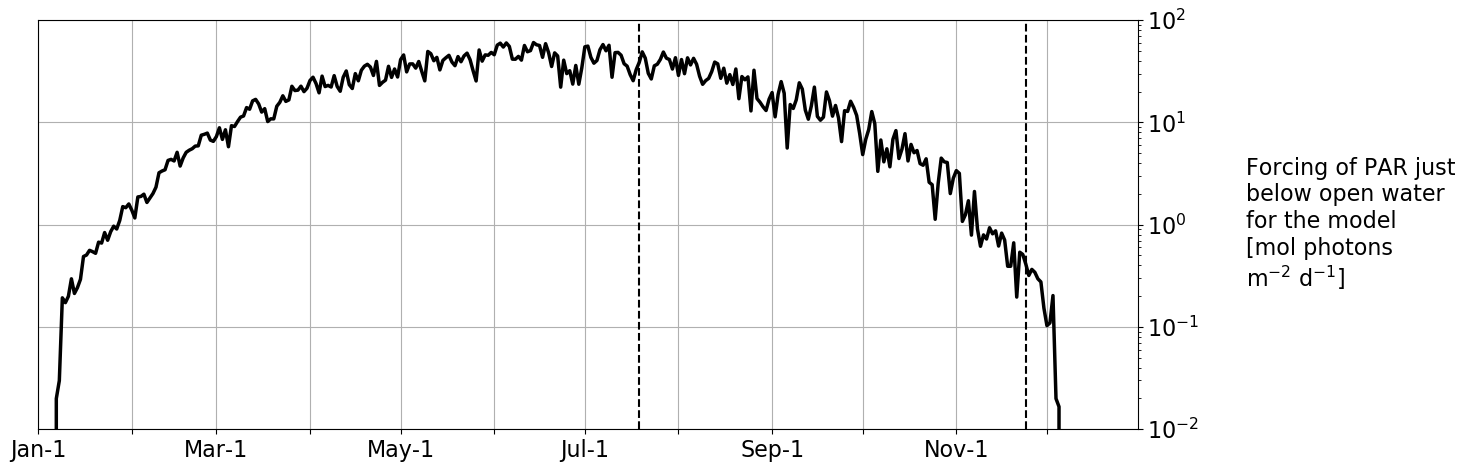

In [30]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','','Mar-1','','May-1','',
        'Jul-1','','Sep-1','','Nov-1','')

plt.figure(figsize=(15,5))
ax = plt.gca()
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.plot(first_year,array1d_iT_PAR_owfile,'k-',lw=2.5)
ax.yaxis.tick_right()
ax.set_yscale('log')
ax.grid()
ax.set_xlim(first_year[0],first_year[-1])
ax.set_ylim(0.01,100.0)
ax.text(400,1,'Forcing of PAR just\nbelow open water\nfor the model\n[mol photons\nm$^{-2}$ d$^{-1}$]',
        horizontalalignment = 'left',
        verticalalignment = 'center')

# adding the vertical line at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')

plt.tight_layout()
plt.savefig('1D_GDPS_PAR_y2016.365.32bits.bin.png')

# Model

## Model: PAR just below surface

In [31]:
array1d_iT_modmeanPAR=array1d_iT_PAR_icefile*ice+array1d_iT_PAR_owfile*(1-ice)

## Model: sPAR_ice

In [32]:
twodfile='2d.0000000000.t001.nc'
array1d_iT_sPAR_icefullumolEm2s=netcdf_tools.read_netcdf(twodfile, 'sPAR_ice').squeeze()
array1d_iT_sPAR_iceumolEm2s=array1d_iT_sPAR_icefullumolEm2s[array1d_iT1y_iT]
stod=86400 # 3600*24 s per d
array1d_iT_sPAR_ice=array1d_iT_sPAR_iceumolEm2s*1e-6*stod

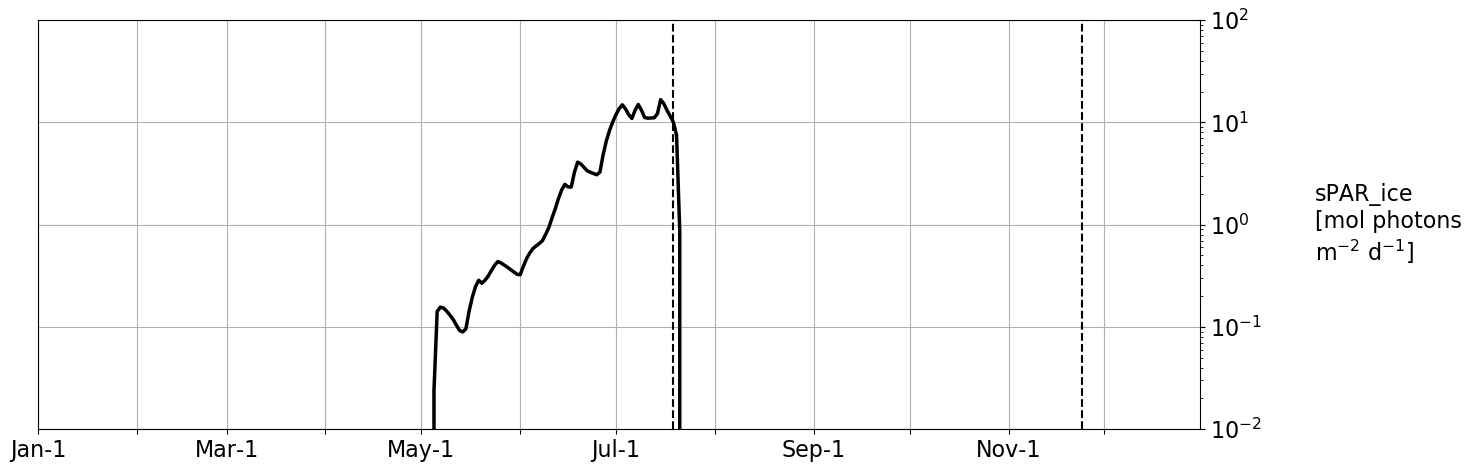

In [33]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','','Mar-1','','May-1','',
        'Jul-1','','Sep-1','','Nov-1','')

plt.figure(figsize=(15,5))
ax = plt.gca()
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.plot(first_year,array1d_iT_sPAR_ice,'k-',lw=2.5)
ax.set_yscale('log')
ax.yaxis.tick_right()
ax.grid()
ax.set_xlim(first_year[0],first_year[-1])
ax.set_ylim(0.01,100.0)
ax.text(400,1,'sPAR_ice\n[mol photons\nm$^{-2}$ d$^{-1}$]',
        horizontalalignment = 'left',
        verticalalignment = 'center')

# adding the vertical line at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')

plt.tight_layout()
plt.savefig('2d.0000000000.t001.lastyear.spar_ice.png')

## Model: sPAR_ow

In [34]:
twodfile='2d.0000000000.t001.nc'
array1d_iT_sPAR_owfullumolEm2s=netcdf_tools.read_netcdf(twodfile, 'sPAR_ow').squeeze()
array1d_iT_sPAR_owumolEm2s=array1d_iT_sPAR_owfullumolEm2s[array1d_iT1y_iT]
stod=86400 # 3600*24 s per d
array1d_iT_sPAR_ow=array1d_iT_sPAR_owumolEm2s*1e-6*stod

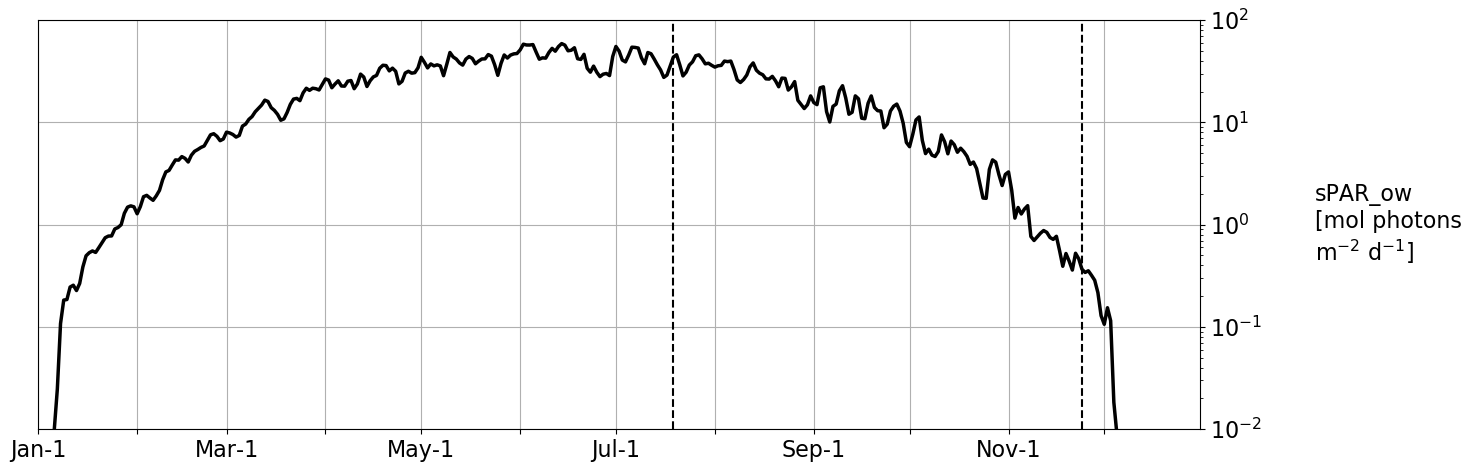

In [35]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','','Mar-1','','May-1','',
        'Jul-1','','Sep-1','','Nov-1','')

plt.figure(figsize=(15,5))
ax = plt.gca()
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.plot(first_year,array1d_iT_sPAR_ow,'k-',lw=2.5)
ax.set_yscale('log')
ax.yaxis.tick_right()
ax.grid()
ax.set_xlim(first_year[0],first_year[-1])
ax.set_ylim(0.01,100.0)
ax.text(400,1,'sPAR_ow\n[mol photons\nm$^{-2}$ d$^{-1}$]',
        horizontalalignment = 'left',
        verticalalignment = 'center')

# adding the vertical line at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')

plt.tight_layout()
plt.savefig('2d.0000000000.t001.lastyear.spar_ow.png')

## Model: PARF_ice

PARF_ice is the PAR under ice at the top of the layer.

In [36]:
carfile='car.0000000000.t001.nc'
array2d_idepth_iT_PARF_icefullumolEonm2s=netcdf_tools.read_netcdf(carfile, 'PARF_ice').squeeze().transpose()
stod=86400 # 3600*24 s per d
array2d_idepth_iT_PARF_icefull=array2d_idepth_iT_PARF_icefullumolEonm2s*1e-6*stod
array2d_idepth_iT_PARF_ice=array2d_idepth_iT_PARF_icefull[:,array1d_iT1y_iT]

marray2d_idepth_iT_PARF_ice=array2d_idepth_iT_PARF_ice.copy()
marray2d_idepth_iT_PARF_ice[marray2d_idepth_iT_PARF_ice<=0]=np.finfo(float).eps
marray2d_idepth_iT_PARF_ice[:,ice==0]=np.ma.masked

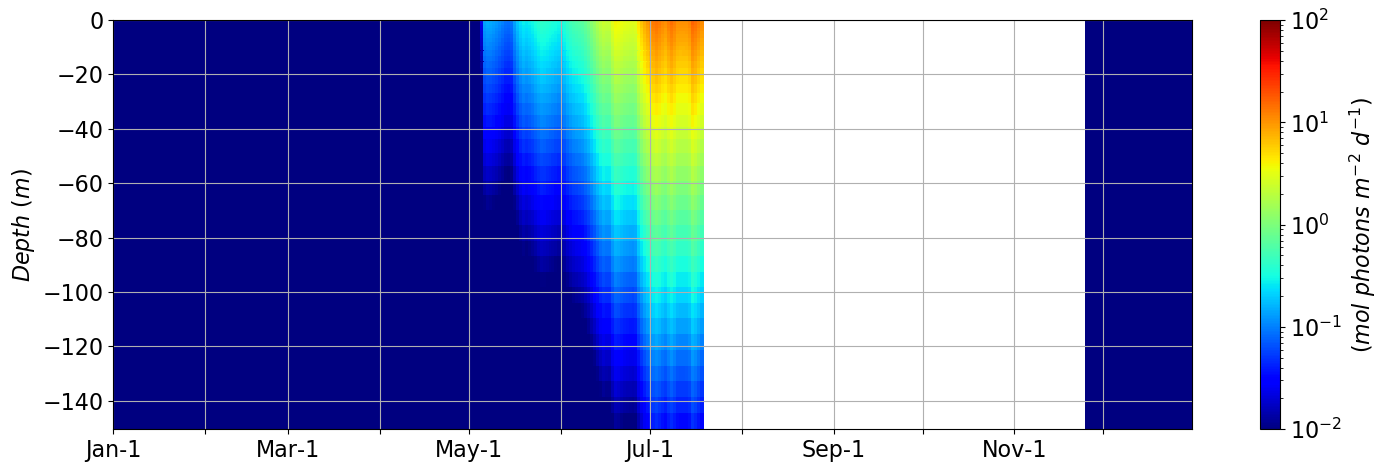

In [37]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','','Mar-1','','May-1','',
        'Jul-1','','Sep-1','','Nov-1','')

RF_above151=RF[RF>-151]

plt.figure(figsize=(15,5))
ax = plt.gca()
h=ax.pcolormesh(first_year366,
                RF_above151,
                marray2d_idepth_iT_PARF_ice[0:(RF_above151.size)-1,:],
                cmap='jet',
                norm=mpl.colors.LogNorm(vmin=0.01,vmax=100)
              )
ax.set_xticklabels([])
ax.set_ylabel('$Depth\ (m)$')
ax.set_xlim(first_year366[0],first_year[-1])
ax.grid()
ax.set_xticks(locs)
ax.set_xticklabels(labels)
cbar=plt.colorbar(h)
cbar.set_label('$(mol\ photons\ m^{-2}\ d^{-1})$')
plt.tight_layout()
plt.savefig('car.0000000000.t001.lastyear.parf_ice.png')

## Model: PARF_ow

PARF_ow is the PAR under open water at the top of the layer.

In [38]:
carfile='car.0000000000.t001.nc'
array2d_idepth_iT_PARF_owfullumolEonm2s=netcdf_tools.read_netcdf(carfile, 'PARF_ow').squeeze().transpose()
stod=86400 # 3600*24 s per d
array2d_idepth_iT_PARF_owfull=array2d_idepth_iT_PARF_owfullumolEonm2s*1e-6*stod
array2d_idepth_iT_PARF_ow=array2d_idepth_iT_PARF_owfull[:,array1d_iT1y_iT]

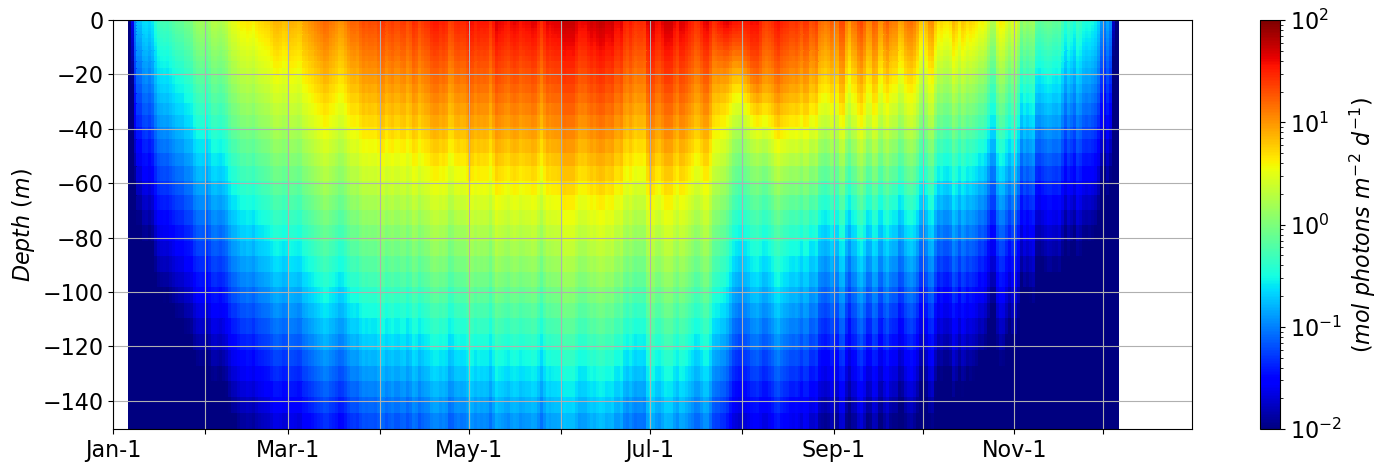

In [39]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','','Mar-1','','May-1','',
        'Jul-1','','Sep-1','','Nov-1','')

RF_above151=RF[RF>-151]

plt.figure(figsize=(15,5))
ax = plt.gca()
h=ax.pcolormesh(first_year366,
                RF_above151,
                array2d_idepth_iT_PARF_ow[0:(RF_above151.size)-1,:],
                cmap='jet',
                norm=mpl.colors.LogNorm(vmin=0.01,vmax=100)
              )
ax.set_xticklabels([])
ax.set_ylabel('$Depth\ (m)$')
ax.set_xlim(first_year366[0],first_year[-1])
ax.grid()
ax.set_xticks(locs)
ax.set_xticklabels(labels)
cbar=plt.colorbar(h)
cbar.set_label('$(mol\ photons\ m^{-2}\ d^{-1})$')
plt.tight_layout()
plt.savefig('car.0000000000.t001.lastyear.parf_ow.png')

## Model: PAR_ice

PAR_ice is the PAR under ice at the center of the layer.

In [40]:
array2d_idepth_iT_PAR_icefullumolEonm2s=netcdf_tools.read_netcdf(carfile, 'PAR_ice').squeeze().transpose()
array2d_idepth_iT_PAR_icefull=array2d_idepth_iT_PAR_icefullumolEonm2s*1e-6*stod
array2d_idepth_iT_PAR_ice=array2d_idepth_iT_PAR_icefull[:,array1d_iT1y_iT]

marray2d_idepth_iT_PAR_ice=array2d_idepth_iT_PAR_ice.copy()
marray2d_idepth_iT_PAR_ice[marray2d_idepth_iT_PAR_ice<=0]=np.finfo(float).eps
marray2d_idepth_iT_PAR_ice[:,ice==0]=np.ma.masked

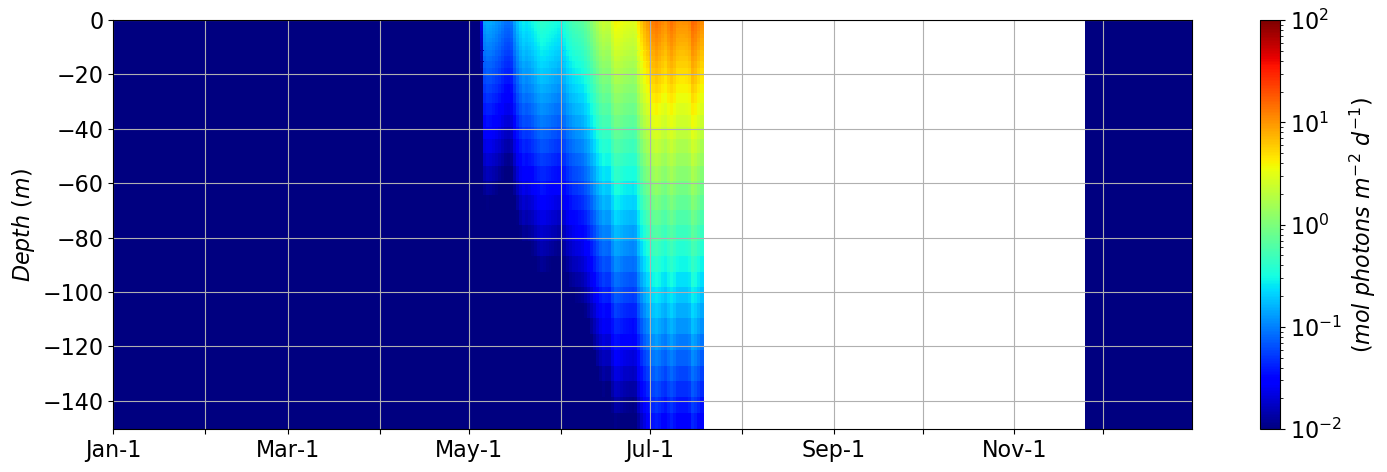

In [41]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','','Mar-1','','May-1','',
        'Jul-1','','Sep-1','','Nov-1','')

RF_above151=RF[RF>-151]

plt.figure(figsize=(15,5))
ax = plt.gca()
h=ax.pcolormesh(first_year366,
                RF_above151,
                marray2d_idepth_iT_PAR_ice[0:(RF_above151.size)-1,:],
                cmap='jet',
                norm=mpl.colors.LogNorm(vmin=0.01,vmax=100)
              )
ax.set_xticklabels([])
ax.set_ylabel('$Depth\ (m)$')
ax.set_xlim(first_year366[0],first_year[-1])
ax.grid()
ax.set_xticks(locs)
ax.set_xticklabels(labels)
cbar=plt.colorbar(h)
cbar.set_label('$(mol\ photons\ m^{-2}\ d^{-1})$')
plt.tight_layout()
plt.savefig('car.0000000000.t001.lastyear.par_ice.png')

## Model: PAR_ow

PAR_ow is the PAR under open water at the center of the layer.

In [42]:
array2d_idepth_iT_PAR_owfullumolEonm2s=netcdf_tools.read_netcdf(carfile, 'PAR_ow').squeeze().transpose()
array2d_idepth_iT_PAR_owfull=array2d_idepth_iT_PAR_owfullumolEonm2s*1e-6*stod
array2d_idepth_iT_PAR_ow=array2d_idepth_iT_PAR_owfull[:,array1d_iT1y_iT]

marray2d_idepth_iT_PAR_ow=array2d_idepth_iT_PAR_ow.copy()
marray2d_idepth_iT_PAR_ow[marray2d_idepth_iT_PAR_ow==0]=np.finfo(float).eps

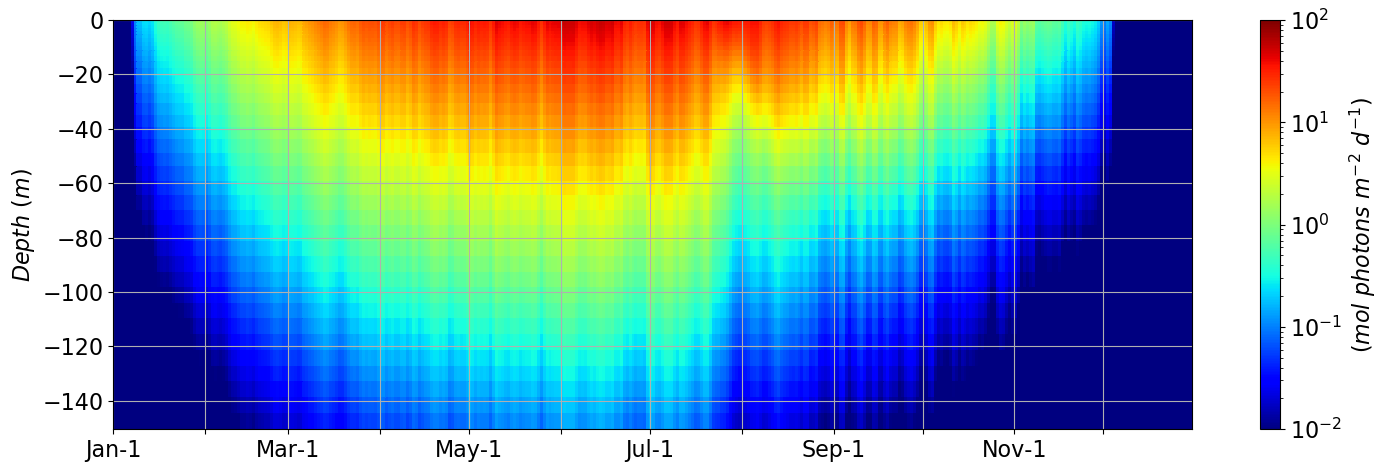

In [43]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','','Mar-1','','May-1','',
        'Jul-1','','Sep-1','','Nov-1','')

RF_above151=RF[RF>-151]

plt.figure(figsize=(15,5))
ax = plt.gca()
h=ax.pcolormesh(first_year366,
                RF_above151,
                marray2d_idepth_iT_PAR_ow[0:(RF_above151.size)-1,:],
                cmap='jet',
                norm=mpl.colors.LogNorm(vmin=0.01,vmax=100)
              )
ax.set_xticklabels([])
ax.set_ylabel('$Depth\ (m)$')
ax.set_xlim(first_year366[0],first_year[-1])
ax.grid()
ax.set_xticks(locs)
ax.set_xticklabels(labels)
cbar=plt.colorbar(h)
cbar.set_label('$(mol\ photons\ m^{-2}\ d^{-1})$')
plt.tight_layout()
plt.savefig('car.0000000000.t001.lastyear.par_ow.png')

## Model: mean PAR

mean PAR is the weighted average of PAR_ow and PAR_ice. This average is weighted using the sea ice concentration.

In [44]:
(ndepths,ndays)=array2d_idepth_iT_PAR_owfull.shape

In [45]:
ndays

3650

In [46]:
nbyears

10

In [47]:
(ndepths,ndays)=array2d_idepth_iT_PAR_owfull.shape
array2d_idepth_iT_icefull=np.tile(ice,(ndepths,nbyears))
array2d_idepth_iT_meanPARfull=array2d_idepth_iT_PAR_owfull*(1-array2d_idepth_iT_icefull)\
+array2d_idepth_iT_PAR_icefull*array2d_idepth_iT_icefull
array2d_idepth_iT_meanPAR=array2d_idepth_iT_meanPARfull[:,array1d_iT1y_iT]

marray2d_idepth_iT_meanPAR=array2d_idepth_iT_meanPAR.copy()
marray2d_idepth_iT_meanPAR[marray2d_idepth_iT_meanPAR<=0]=np.finfo(float).eps

In [48]:
plt.rcdefaults()

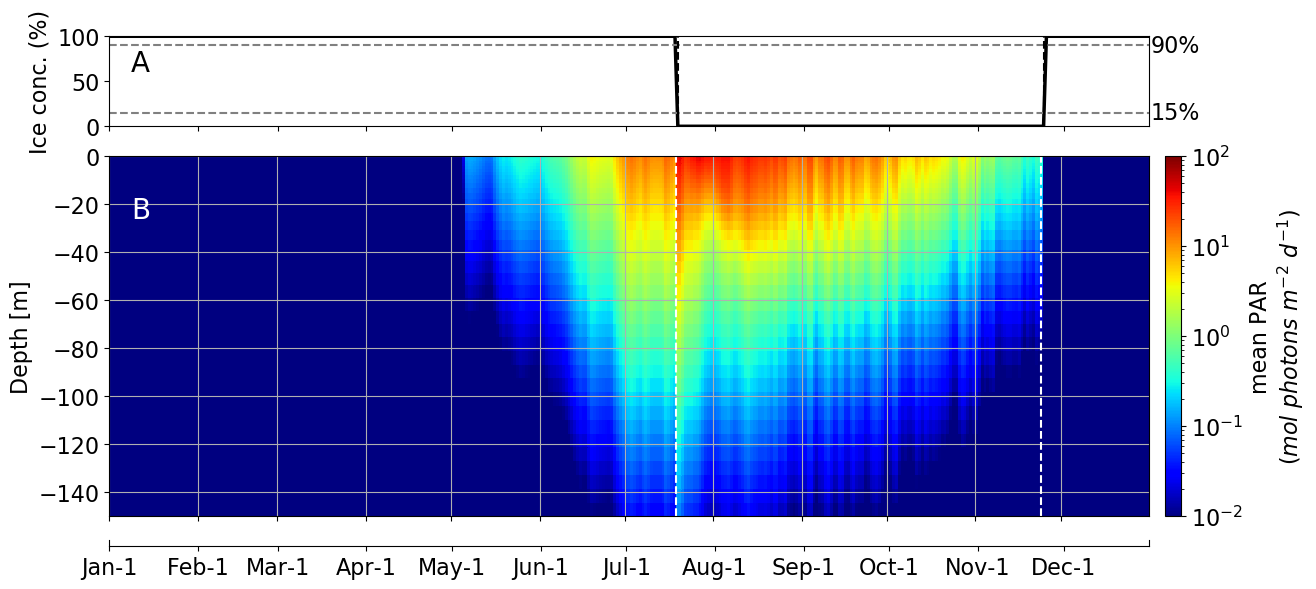

In [49]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
        'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

RF_above151=RF[RF>-151]
fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

# --- ICE CONCENTRATIONS
ax=axs[0]
ax.plot(first_year,ice*100,'k-',lw=2.5)
ax.set_xlim(first_year[0],first_year[-1])
xlims=ax.get_xlim()
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Ice conc. (%)')
ax.set_ylim(0,100)
ax.plot(xlims,[15,15],'k--',color='gray')
ax.plot(xlims,[90,90],'k--',color='gray')
ax.text(xlims[1]+.5,15,'15%',verticalalignment='center')
ax.text(xlims[1]+.5,90,'90%',verticalalignment='center')
plt.text(0.03,0.7,'A',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20)

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')

# --- PANEL D: MEAN PAR
ax=axs[1]
RF_above151=RF[RF>-151]
h=ax.pcolormesh(first_year366,
                RF_above151,
                marray2d_idepth_iT_meanPAR[0:(RF_above151.size)-1,:],
                cmap='jet',
                norm=mpl.colors.LogNorm(vmin=0.01,vmax=100))
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Depth [m]')
ax.set_ylim(-150,0)
ax.grid()

# adding the colorbar
cbaxes = fig.add_axes([0.78, 0.15, 0.01, 0.60])
cb = plt.colorbar(h,
                  cax=cbaxes)
cb.set_label('mean PAR\n($mol\ photons\ m^{-2}\ d^{-1}$)')

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='w',linestyle='--')
ax.axvline(iT15_end,  color='w',linestyle='--')

plt.text(0.03,0.85,'B',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20, color='w')

# --- ADDITIONAL X-AXIS
ax=axs[2]
ax.set_xlim(xlims)
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)

# --- POSITION
axs[0].set_position( [0.12,0.80  ,0.65,0.15])
axs[1].set_position( [0.12,0.15  ,0.65,0.60])
axs[2].set_position( [0.12,0.10  ,0.65,0.01])

# --- SAVE
plt.savefig('car.0000000000.t001.lastyear.meanPAR.png')

# Comparisons

## Comparison: PAR just below the surface

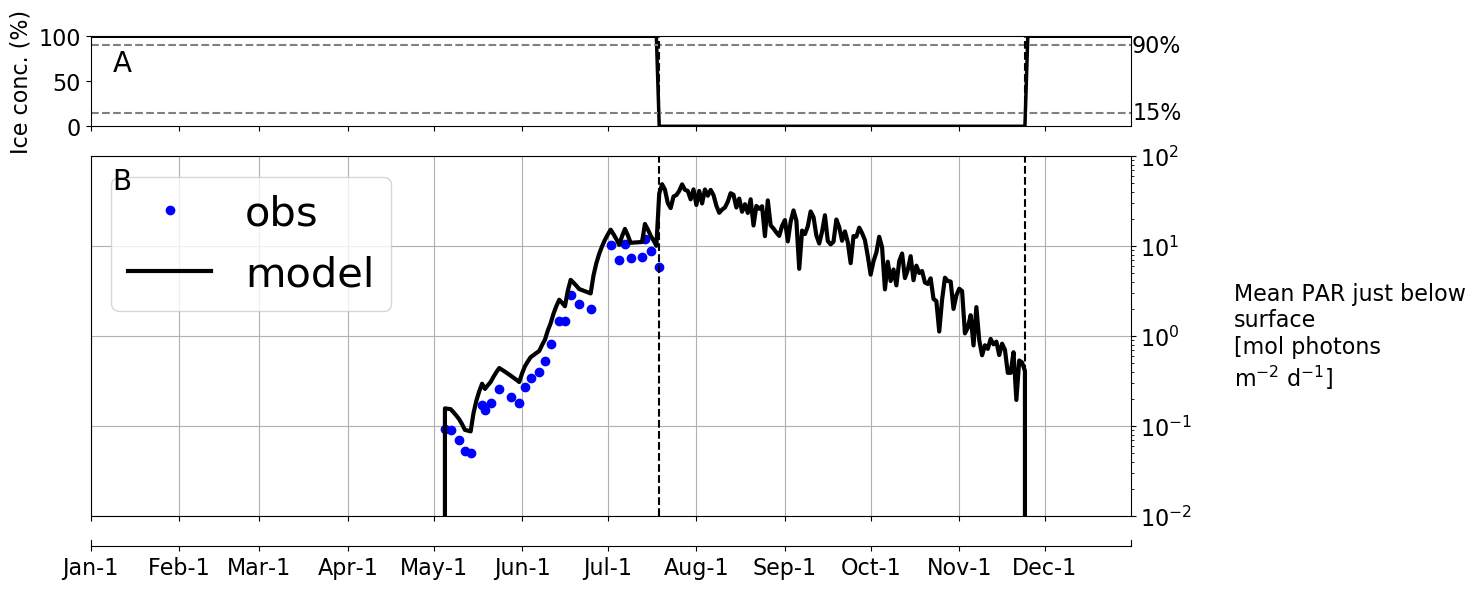

In [50]:
locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
        'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

# --- ICE CONCENTRATIONS
ax=axs[0]
ax.plot(first_year,ice*100,'k-',lw=2.5)
ax.set_xlim(first_year[0],first_year[-1])
xlims=ax.get_xlim()
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Ice conc. (%)')
ax.set_ylim(0,100)
ax.plot(xlims,[15,15],'k--',color='gray')
ax.plot(xlims,[90,90],'k--',color='gray')
ax.text(xlims[1]+.5,15,'15%',verticalalignment='center')
ax.text(xlims[1]+.5,90,'90%',verticalalignment='center')
plt.text(0.03,0.7,'A',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20)

# adding the vertical line at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,color='k',linestyle='--')

# --- PAR JUST BELOW THE SURFACE
ax=axs[1]
h1=ax.plot(first_year,
           array1d_iT_obsmeanPAR,
           'o',
           color='blue',
           label='obs')
ax.set_yscale('log')
h2=ax.plot(first_year,
           array1d_iT_modmeanPAR,
           '-',
           lw=3,
           color='black',
           label='model')
ax.set_xlim(xlims)
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.yaxis.tick_right()
ax.set_ylim(0.01,100)
ax.legend(fontsize=30)
ax.grid()

ax.text(400,1,'Mean PAR just below\nsurface\n[mol photons\nm$^{-2}$ d$^{-1}$]',
        horizontalalignment = 'left',
        verticalalignment = 'center')
plt.text(0.03,0.93,'B',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20)

# adding the vertical line at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,color='k',linestyle='--')

# --- ADDITIONAL X-AXIS
ax=axs[2]
ax.set_xlim(xlims)
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)

# --- POSITION
axs[0].set_position( [0.12,0.80  ,0.65,.15])
axs[1].set_position( [0.12,0.15  ,0.65,.60])
axs[2].set_position( [0.12,0.10  ,0.65,.01])

# --- SAVE
plt.savefig('validation/GEic2016.comp.logPAR0minus.png')

# Relations between many variables

## Comparison between observations and forcings: PAR just below surface

In [51]:
plt.rcdefaults()

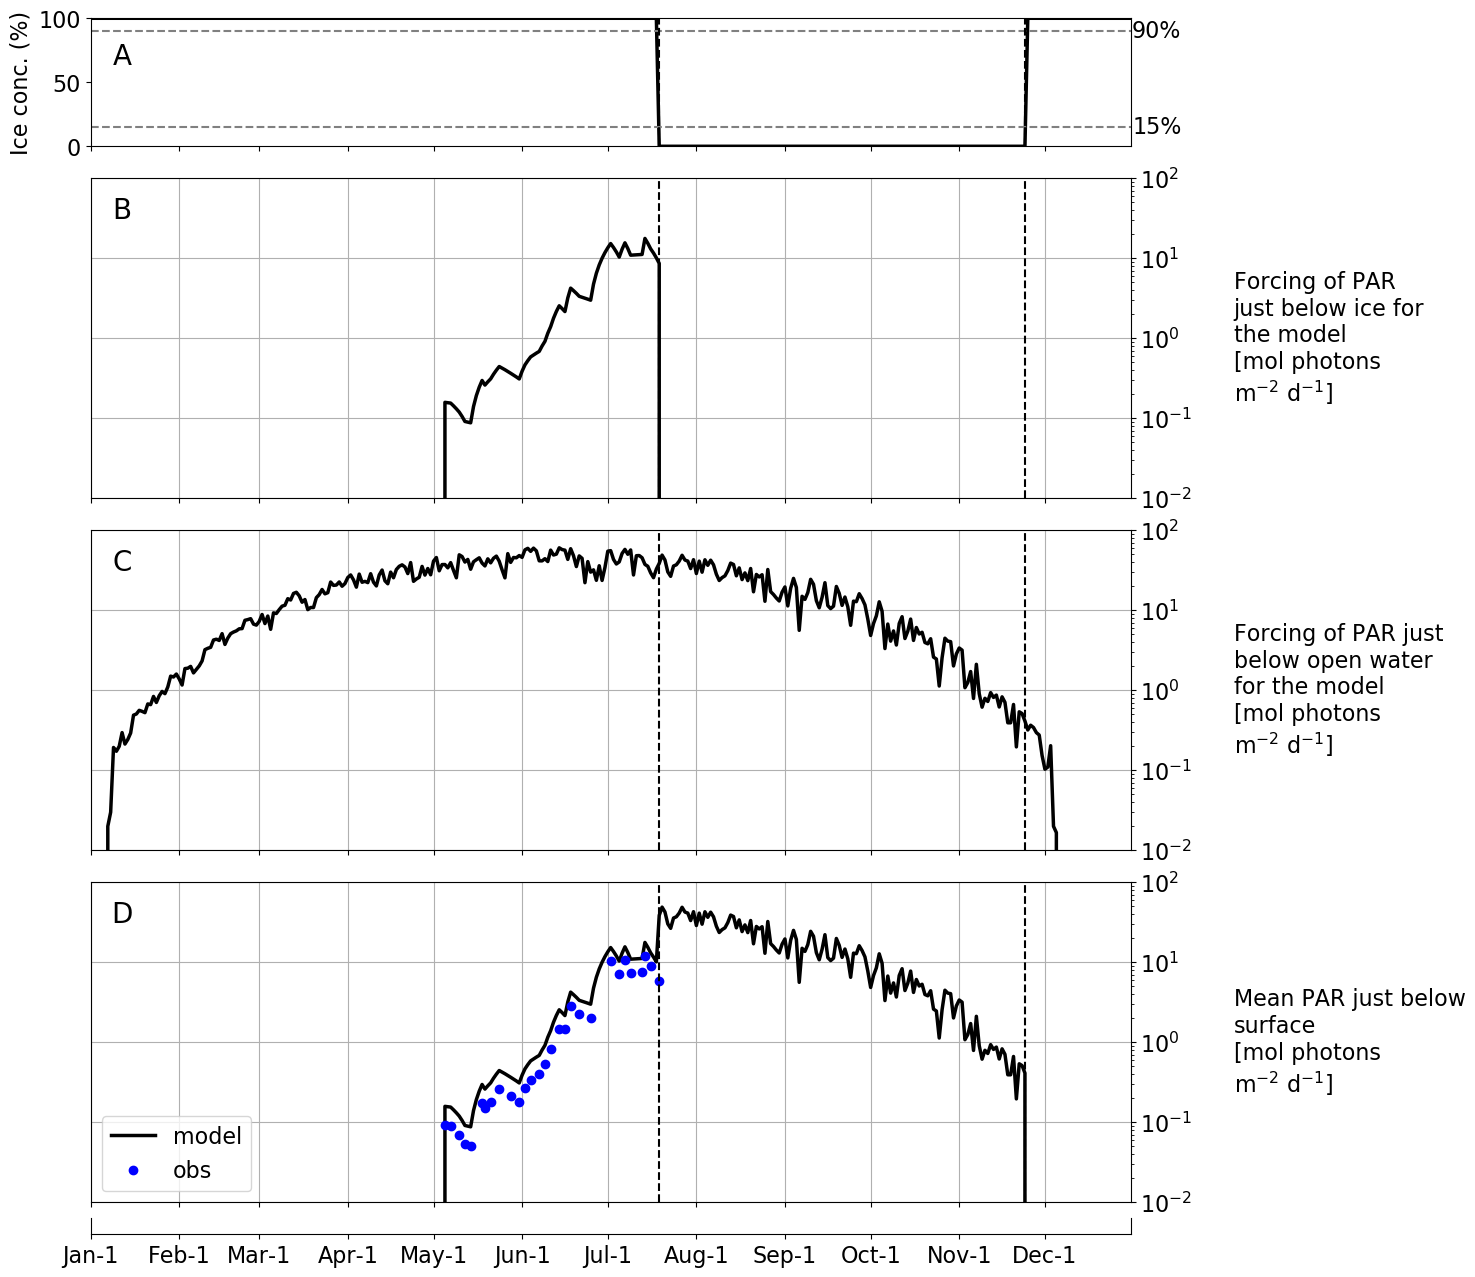

In [52]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
        'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

fig,axs=plt.subplots(5,1,sharex=False,figsize=(16, 16))

nT=ice.size

# --- ICE CONCENTRATIONS
ax=axs[0]
ax.plot(first_year,ice*100,'k-',lw=2.5)
ax.set_xlim(first_year[0],first_year[-1])
xlims=ax.get_xlim()
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Ice conc. (%)')
ax.set_ylim(0,100)
ax.plot(xlims,[15,15],'k--',color='gray')
ax.plot(xlims,[90,90],'k--',color='gray')
ax.text(xlims[1]+.5,15,'15%',verticalalignment='center')
ax.text(xlims[1]+.5,90,'90%',verticalalignment='center')
plt.text(0.03,0.7,'A',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20)

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')

# --- PANEL B: FORCING OF PAR JUST BELOW ICE FOR THE MODEL

ax=axs[1]
ax.set_xticklabels([])
ax.set_xticks(locs)
h1=ax.plot(first_year,array1d_iT_PAR_icefile,'k-',lw=2.5)
ax.set_yscale('log')
ax.yaxis.tick_right()
ax.grid()
ax.set_xlim(xlims)
ax.set_ylim(0.01,100.0)
ax.text(400,1,'Forcing of PAR\njust below ice for\nthe model\n[mol photons\nm$^{-2}$ d$^{-1}$]',
        horizontalalignment = 'left',
        verticalalignment = 'center')
plt.text(0.03,0.9,'B',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20)

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')

# --- PANEL C: FORCING OF PAR JUST BELOW OPEN WATER FOR THE MODEL
ax=axs[2]
ax.set_xticklabels([])
ax.set_xticks(locs)
h1=ax.plot(first_year,array1d_iT_PAR_owfile,'k-',lw=2.5)
ax.set_yscale('log')
ax.yaxis.tick_right()
ax.grid()
ax.set_xlim(xlims)
ax.set_ylim(0.01,100.0)
ax.text(400,1,'Forcing of PAR just\nbelow open water\nfor the model\n[mol photons\nm$^{-2}$ d$^{-1}$]',
        horizontalalignment = 'left',
        verticalalignment = 'center')
plt.text(0.03,0.9,'C',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20)

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')

# --- PANEL D: PAR JUST BELOW SURFACE
ax=axs[3]
ax.set_xticklabels([])
ax.set_xticks(locs)
h1=ax.plot(first_year,
           array1d_iT_modmeanPAR,
           '-',
           color='black',
           lw=2.5,
           label='model')
h2=ax.plot(first_year,
           array1d_iT_obsmeanPAR,
           'o',
           color='blue',
           label='obs')
ax.set_yscale('log')
ax.yaxis.tick_right()
ax.grid()
ax.set_xlim(xlims)
ax.set_ylim(0.01,100.0)
ax.legend(loc='lower left')
ax.text(400,1,'Mean PAR just below\nsurface\n[mol photons\nm$^{-2}$ d$^{-1}$]',
        horizontalalignment = 'left',
        verticalalignment = 'center')
plt.text(0.03,0.9,'D',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20)

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')


# --- ADDITIONAL X-AXIS
ax=axs[4]
ax.set_xlim(xlims)
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)

# --- POSITION
axs[0].set_position( [0.12,0.88  ,0.65,.08])
axs[1].set_position( [0.12,0.66  ,0.65,.20])
axs[2].set_position( [0.12,0.44  ,0.65,.20])
axs[3].set_position( [0.12,0.22  ,0.65,.20])
axs[4].set_position( [0.12,0.20  ,0.65,.01])

# --- SAVE
plt.savefig('validation/GEic2016.comp.PAR0minus.all.png')

## Model: PAR

In [53]:
plt.rcdefaults()

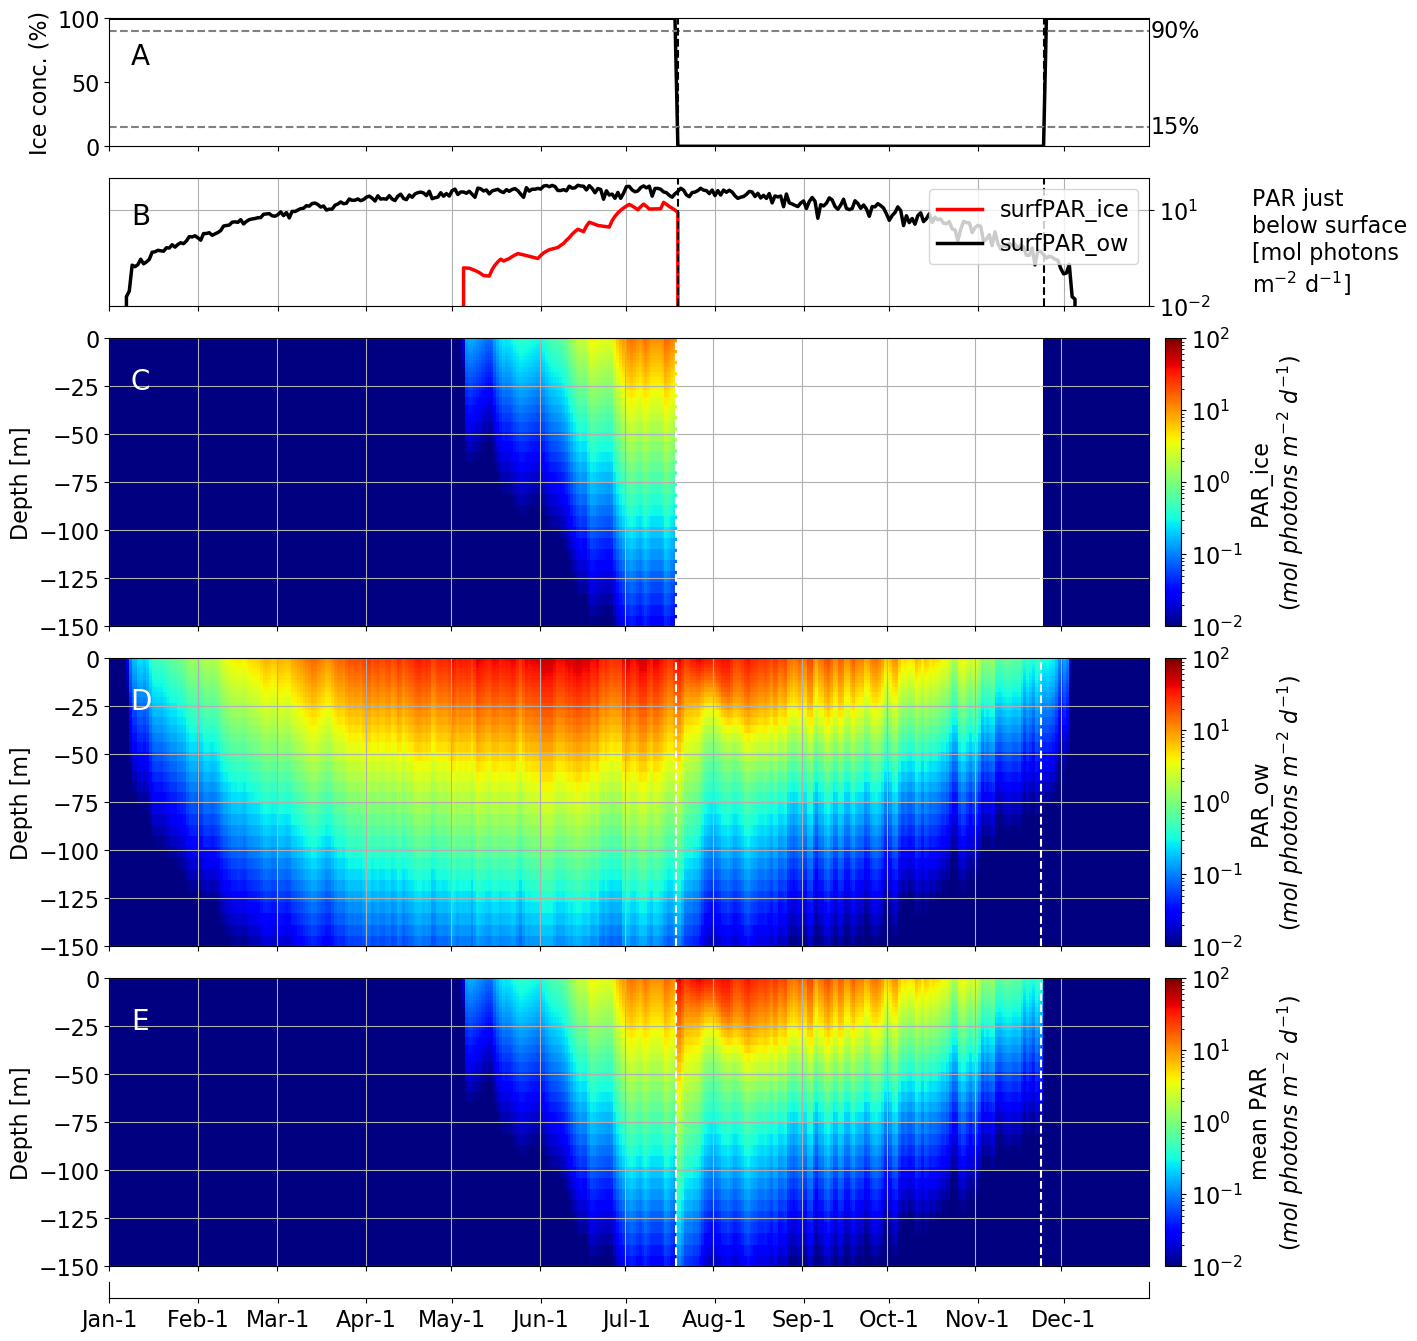

In [54]:
mpl.rc('font', **{'size' : 16})

locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
        'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

fig,axs=plt.subplots(6,1,sharex=False,figsize=(16, 16))

# --- ICE CONCENTRATIONS
ax=axs[0]
ax.plot(first_year,ice*100,'k-',lw=2.5)
ax.set_xlim(first_year[0],first_year[-1])
xlims=ax.get_xlim()
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Ice conc. (%)')
ax.set_ylim(0,100)
ax.plot(xlims,[15,15],'k--',color='gray')
ax.plot(xlims,[90,90],'k--',color='gray')
ax.text(xlims[1]+.5,15,'15%',verticalalignment='center')
ax.text(xlims[1]+.5,90,'90%',verticalalignment='center')
plt.text(0.03,0.7,'A',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20)

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')

# --- PANEL B: PAR JUST BELOW ICE AND JUST BELOW OPEN WATER
ax=axs[1]
ax.set_xticklabels([])
ax.set_xticks(locs)
h1=ax.plot(first_year,array1d_iT_PAR_icefile,'r-',lw=2.5)
ax.set_yscale('log')
ax.yaxis.tick_right()
ax.grid()
ax.set_xlim(xlims)
ax.set_ylim(0.01,100.0)
ax.text(400,1,'PAR just\nbelow surface\n[mol photons\nm$^{-2}$ d$^{-1}$]',
        horizontalalignment = 'left',
        verticalalignment = 'center')
plt.text(0.03,0.7,'B',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20)
h2=ax.plot(first_year,array1d_iT_PAR_owfile,'k-',lw=2.5)
ax.legend([h1[0],h2[0]],['surfPAR_ice','surfPAR_ow'],loc=1)

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')
ax.axvline(iT15_end,  color='k',linestyle='--')

# --- PANEL C: PAR UNDER ICE
ax=axs[2]
RF_above151=RF[RF>-151]
h=ax.pcolormesh(first_year366,
                RF_above151,
                marray2d_idepth_iT_PAR_ice[0:(RF_above151.size)-1,:],
                cmap='jet',
                norm=mpl.colors.LogNorm(vmin=0.01,vmax=100))
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Depth [m]')
ax.set_ylim(-150,0)
ax.grid()

# adding the colorbar
cbaxes = fig.add_axes([0.78, 0.58, 0.01, 0.18])
cb = plt.colorbar(h,
                  cax=cbaxes)
cb.set_label('PAR_ice\n($mol\ photons\ m^{-2}\ d^{-1}$)')

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='w',linestyle='--')
ax.axvline(iT15_end,  color='w',linestyle='--')

plt.text(0.03,0.85,'C',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20, color='w')

# --- PANEL D: PAR UNDER OPEN WATER
ax=axs[3]
RF_above151=RF[RF>-151]
h=ax.pcolormesh(first_year366,
                RF_above151,
                marray2d_idepth_iT_PAR_ow[0:(RF_above151.size)-1,:],
                cmap='jet',
                norm=mpl.colors.LogNorm(vmin=0.01,vmax=100))
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Depth [m]')
ax.set_ylim(-150,0)
ax.grid()

# adding the colorbar
cbaxes = fig.add_axes([0.78, 0.38, 0.01, 0.18])
cb = plt.colorbar(h,
                  cax=cbaxes)
cb.set_label('PAR_ow\n($mol\ photons\ m^{-2}\ d^{-1}$)')

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='w',linestyle='--')
ax.axvline(iT15_end,  color='w',linestyle='--')

plt.text(0.03,0.85,'D',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20, color='w')

# --- PANEL E: MEAN PAR
ax=axs[4]
RF_above151=RF[RF>-151]
h=ax.pcolormesh(first_year366,
                RF_above151,
                marray2d_idepth_iT_meanPAR[0:(RF_above151.size)-1,:],
                cmap='jet',
                norm=mpl.colors.LogNorm(vmin=0.01,vmax=100))
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Depth [m]')
ax.set_ylim(-150,0)
ax.grid()

# adding the colorbar
cbaxes = fig.add_axes([0.78, 0.18, 0.01, 0.18])
cb = plt.colorbar(h,
                  cax=cbaxes)
cb.set_label('mean PAR\n($mol\ photons\ m^{-2}\ d^{-1}$)')

# adding the vertical lines at 15% of ice
ax.axvline(iT15_start,color='w',linestyle='--')
ax.axvline(iT15_end,  color='w',linestyle='--')

plt.text(0.03,0.85,'E',
         horizontalalignment = 'center',verticalalignment='center',
         transform=ax.transAxes, fontsize=20, color='w')

# --- ADDITIONAL X-AXIS
ax=axs[5]
ax.set_xlim(xlims)
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)

# --- POSITION
axs[0].set_position( [0.12,0.88  ,0.65,.08])
axs[1].set_position( [0.12,0.78  ,0.65,.08])
axs[2].set_position( [0.12,0.58  ,0.65,.18])
axs[3].set_position( [0.12,0.38  ,0.65,.18])
axs[4].set_position( [0.12,0.18  ,0.65,.18])
axs[5].set_position( [0.12,0.16  ,0.65,.01])

# --- SAVE
plt.savefig('one_year_par.png')